In [1]:
from util.detection_util import read_image_stack, distance_mat
from util.display_util import get_rgb_projected

from scipy.ndimage import gaussian_laplace, maximum_filter, maximum_position, zoom
from scipy.optimize import linear_sum_assignment
from scipy.signal import resample
from skimage.feature import peak_local_max
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 10]

In [6]:
channel1_file = '/Volumes/tmp/Daaaaaavid/A557-12/o_A557-12.tif'
channel2_file = '/Volumes/tmp/Daaaaaavid/A557-12/r_A557-12.tif'
dapi_file = '/Volumes/tmp/Daaaaaavid/A557-12/b_A557-12.tif'

img_channel1 = np.array(read_image_stack(channel1_file), dtype=float)
img_channel2 = np.array(read_image_stack(channel2_file), dtype=float)
img_dapi = np.array(read_image_stack(dapi_file), dtype=float)

z-resampling: 7.5
sigmas: [ 2.65413063  2.65413063  1.        ]


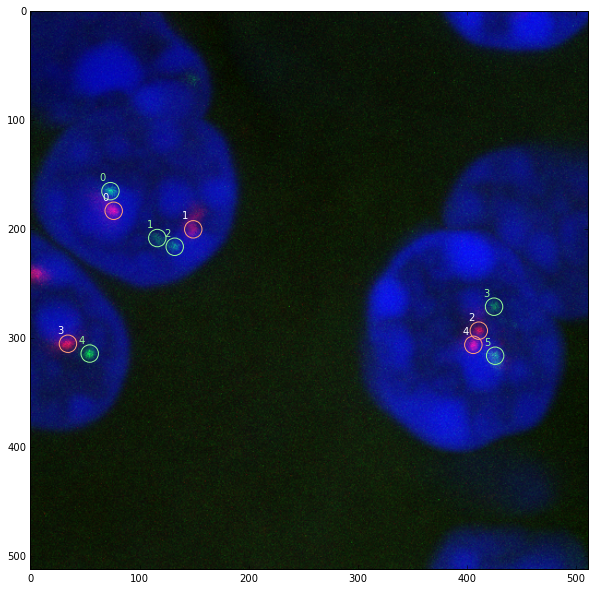

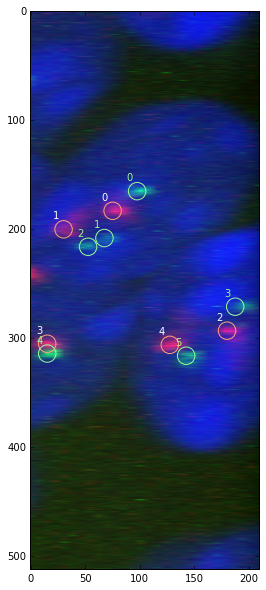

In [8]:
pixelsize = [40, 40, 300]
expected_size = [250, 250, 500]

threshold_channel1 = 25
threshold_channel2 = 15

z_resample = pixelsize[2] / pixelsize[0]
print('z-resampling: ' + str(z_resample))

sigmas = np.array(expected_size, dtype=float) / np.array(pixelsize, dtype=float) / (2. * np.sqrt(2. * np.log(2.)))
sigmas[sigmas < 1] = 1.0
print('sigmas: ' + str(sigmas))

img_rgb = get_rgb_projected(img_channel1, img_channel2, img_dapi)
img_rgb_xz = get_rgb_projected(img_channel1, img_channel2, img_dapi, axis=1)
img_rgb_xz = zoom(img_rgb_xz, (1, z_resample, 1), order=1)

log1 = - gaussian_laplace(img_channel1, sigmas)
pks1 = peak_local_max(log1, threshold_abs=threshold_channel1)
log2 = - gaussian_laplace(img_channel2, sigmas)
pks2 = peak_local_max(log2, threshold_abs=threshold_channel2)

plt.imshow(img_rgb)

for i in range(len(pks1)):
    d = pks1[i]
    c = plt.Circle((d[1], d[0]), 8, color='lightsalmon', linewidth=1, fill=False)
    plt.text(d[1] - 10, d[0] - 10, str(i), color='white')
    plt.gca().add_patch(c)
    plt.draw()

for i in range(len(pks2)):
    d = pks2[i]
    c = plt.Circle((d[1], d[0]), 8, color='palegreen', linewidth=1, fill=False)
    plt.text(d[1] - 10, d[0] - 10, str(i), color='palegreen')
    plt.gca().add_patch(c)
    plt.draw()    

plt.figure()
plt.imshow(img_rgb_xz)

for i in range(len(pks1)):
    d = pks1[i]
    c = plt.Circle((d[2] * z_resample, d[0]), 8, color='lightsalmon', linewidth=1, fill=False)
    plt.text(d[2] * z_resample - 10, d[0] - 10, str(i), color='white')
    plt.gca().add_patch(c)
    plt.draw()

for i in range(len(pks2)):
    d = pks2[i]
    c = plt.Circle((d[2] * z_resample, d[0]), 8, color='palegreen', linewidth=1, fill=False)
    plt.text(d[2] * z_resample - 10, d[0] - 10, str(i), color='palegreen')
    plt.gca().add_patch(c)
    plt.draw()    


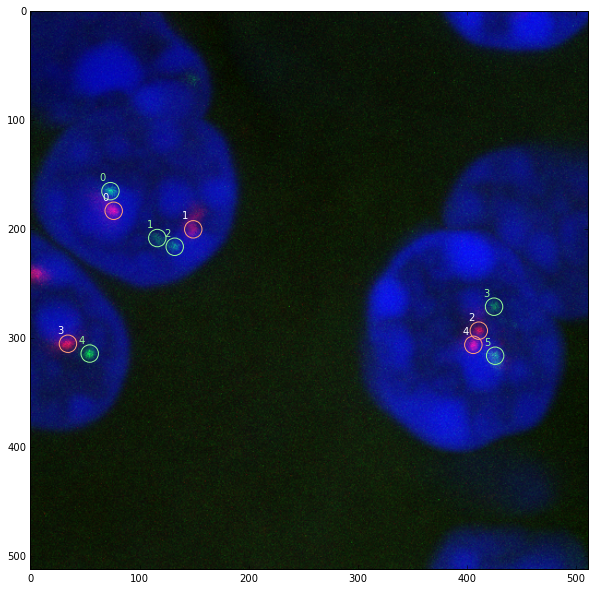

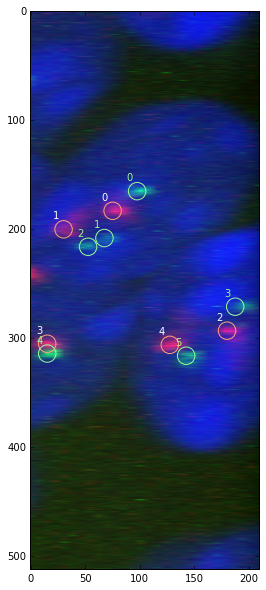

In [9]:
points_to_remove_channel1 = []
points_to_remove_channel2 = []

pks1i = pks1[[i for i in range(pks1.shape[0]) if i not in points_to_remove_channel1]]
pks2i = pks2[[i for i in range(pks2.shape[0]) if i not in points_to_remove_channel2]]

plt.imshow(img_rgb)

for i in range(len(pks1i)):
    d = pks1i[i]
    c = plt.Circle((d[1], d[0]), 8, color='lightsalmon', linewidth=1, fill=False)
    plt.text(d[1] - 10, d[0] - 10, str(i), color='white')
    plt.gca().add_patch(c)
    plt.draw()

for i in range(len(pks2i)):
    d = pks2i[i]
    c = plt.Circle((d[1], d[0]), 8, color='palegreen', linewidth=1, fill=False)
    plt.text(d[1] - 10, d[0] - 10, str(i), color='palegreen')
    plt.gca().add_patch(c)
    plt.draw()    

plt.figure()
plt.imshow(img_rgb_xz)

for i in range(len(pks1i)):
    d = pks1i[i]
    c = plt.Circle((d[2] * z_resample, d[0]), 8, color='lightsalmon', linewidth=1, fill=False)
    plt.text(d[2] * z_resample - 10, d[0] - 10, str(i), color='white')
    plt.gca().add_patch(c)
    plt.draw()

for i in range(len(pks2i)):
    d = pks2i[i]
    c = plt.Circle((d[2] * z_resample, d[0]), 8, color='palegreen', linewidth=1, fill=False)
    plt.text(d[2] * z_resample - 10, d[0] - 10, str(i), color='palegreen')
    plt.gca().add_patch(c)
    plt.draw()    

## calculate spot pairs and display them

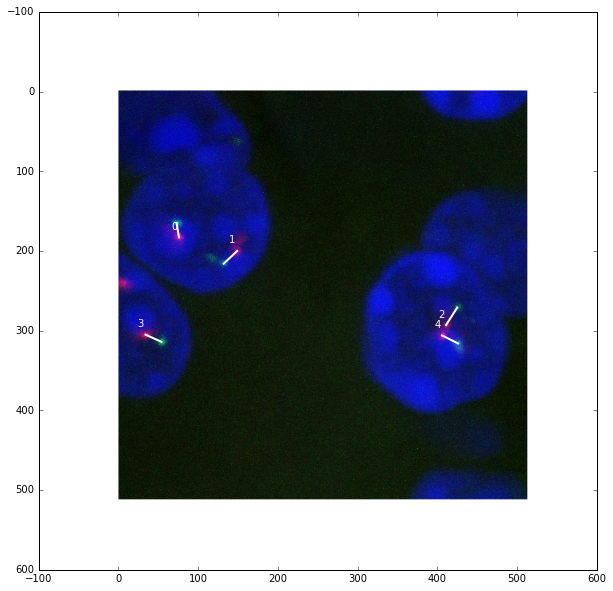

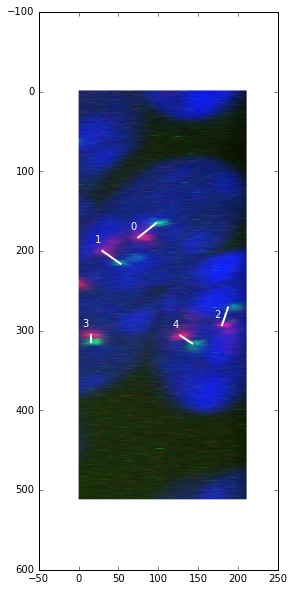

In [10]:
lines_to_ignore = []
lines_to_remove = []


cij = distance_mat(pks1i, pks2i, lines_to_ignore, np.array(pixelsize, dtype=float))
row, col = linear_sum_assignment(cij)

plt.imshow(img_rgb)

for i in row:
    if i in lines_to_remove:
        continue
    if not i in range(pks1i.shape[0]):
        continue
    if not col[i] in range(pks2i.shape[0]):
        continue
    p1 = pks1i[i]
    p2 = pks2i[col[i]]
    plt.text(p1[1] - 10, p1[0] - 10, str(i), color='white')
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], '-', color='white', lw=2)
    plt.draw()
    
plt.figure()
plt.imshow(img_rgb_xz)

for i in row:
    if i in lines_to_remove:
        continue
    if not i in range(pks1i.shape[0]):
        continue
    if not col[i] in range(pks2i.shape[0]):
        continue
    p1 = pks1i[i]
    p2 = pks2i[col[i]]
    plt.text(p1[2] * z_resample - 10, p1[0] - 10, str(i), color='white')
    plt.plot([p1[2] * z_resample, p2[2] * z_resample], [p1[0], p2[0]], '-', color='white', lw=2)
    plt.draw()

In [20]:
res = pd.DataFrame()

xch1 = []
xch2 = []
ych1 = []
ych2 = []
zch1 = []
zch2 = []

for i in row:
    if i in lines_to_remove:
        continue
    if not i in range(pks1i.shape[0]):
        continue
    if not col[i] in range(pks2i.shape[0]):
        continue
    p1 = pks1i[i] * np.array(pixelsize, dtype=float)
    p2 = pks2i[col[i]] * np.array(pixelsize, dtype=float)
    
    xch1.append(p1[1])
    xch2.append(p2[1])
    ych1.append(p1[0])
    ych2.append(p2[0])
    zch1.append(p1[2])
    zch2.append(p2[2])
    
res['xch1'] = xch1
res['xch2'] = xch2
res['ych1'] = ych1
res['ych2'] = ych2
res['zch1'] = zch1
res['zch2'] = zch2

res['distance'] = np.sqrt((res.xch1 - res.xch2)**2 + (res.ych1 - res.ych2)**2 + (res.zch1 - res.zch2)**2)

res.to_csv('/Volumes/tmp/Daaaaaavid/A557-12/result.csv')
res